# Insurance Policy Binary Classification

## [1] Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer 

from sklearn.pipeline import Pipeline

## [2] Load and Split the Data

In [2]:
# Whole Dataset
data = pd.read_csv("TrainingDataset_2023Qualification.csv")

In [3]:
# Split the Features and Target Variables
features = data.iloc[:, 2:]
target = data.iloc[:, 1]

In [4]:
# Split the Data into Training and Testing Sets
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.25)

## [3] Exploratory Data Analysis

### [3.1] Explore the Data

In [5]:
# Check Data Types
x_train.dtypes

Gender                        object
policyHolderAge                int64
hasCanadianDrivingLicense      int64
territory                      int64
hasAutoInsurance               int64
hadVehicleClaimInPast         object
homeInsurancePremium           int64
saleChannel                    int64
isOwner                        int64
rentedVehicle                  int64
hasMortgage                  float64
nbWeeksInsured                 int64
vehicleStatus                 object
dtype: object

#### 3.1.1 Numerical Continuous Variables

In [6]:
# Explore Numerical Continuous Variables for Anomalies [Outliers]
x_train[["policyHolderAge", "homeInsurancePremium", "nbWeeksInsured"]].describe()

,policyHolderAge,homeInsurancePremium,nbWeeksInsured
count,112402.000000,112402.000000,112402.000000
mean,38.813437,1018.086004,22.469992
std,15.773536,575.962612,12.058638
min,18.000000,88.000000,0.000000
25%,25.000000,813.000000,12.000000
50%,36.000000,1056.000000,22.000000
75%,50.000000,1312.000000,33.000000
max,89.000000,18006.000000,45.000000


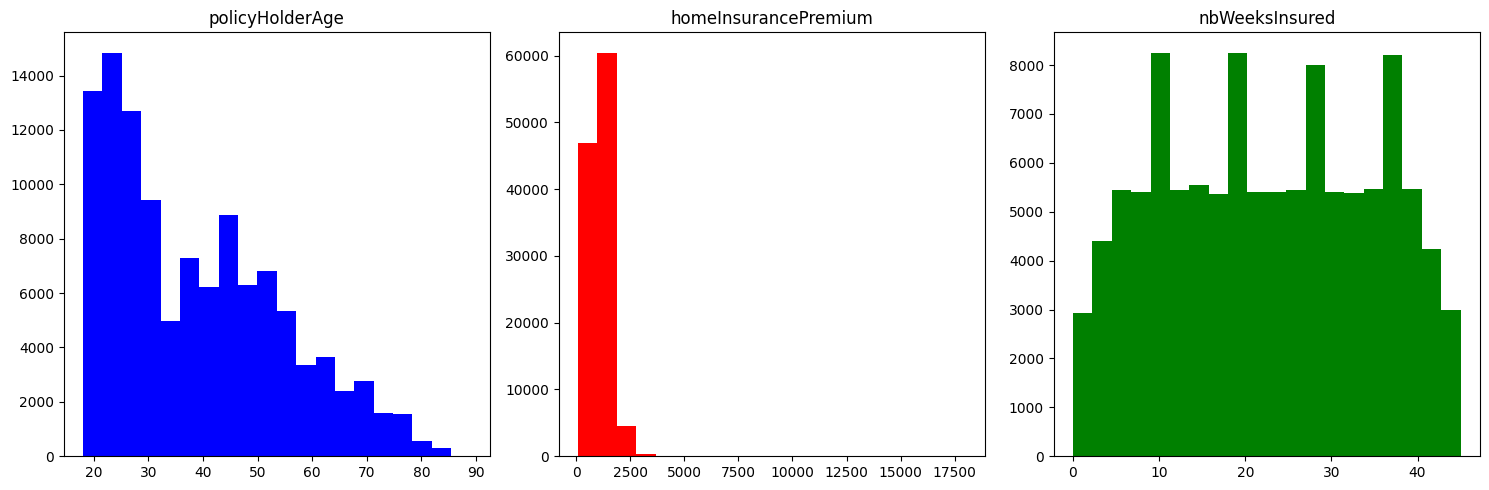

In [7]:
# Plot a Histogram of the Numerical Variables
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].hist(x_train["policyHolderAge"], bins=20, color='blue')
ax[0].set_title('policyHolderAge')
ax[1].hist(x_train["homeInsurancePremium"], bins=20, color='red')
ax[1].set_title('homeInsurancePremium')
ax[2].hist(x_train["nbWeeksInsured"], bins=20, color='green')
ax[2].set_title('nbWeeksInsured')

fig.tight_layout()

plt.show()

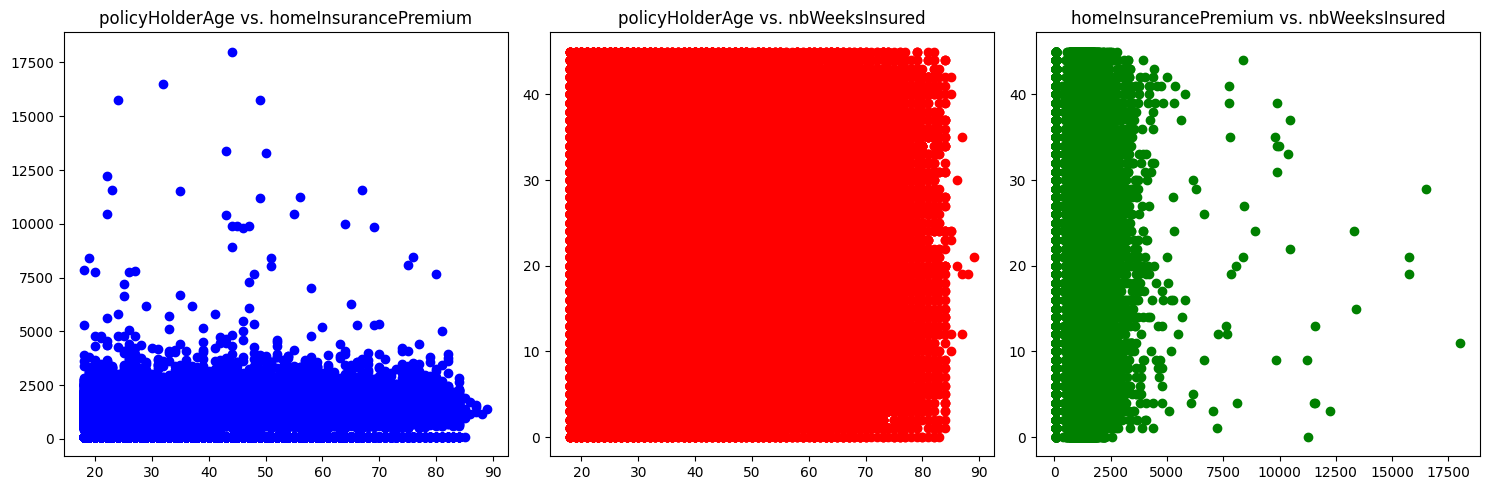

In [8]:
# Plot a Scatterplot of the Numerical Variables
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].scatter(x_train["policyHolderAge"], x_train["homeInsurancePremium"], color='blue')
ax[0].set_title('policyHolderAge vs. homeInsurancePremium')
ax[1].scatter(x_train["policyHolderAge"], x_train["nbWeeksInsured"], color='red')
ax[1].set_title('policyHolderAge vs. nbWeeksInsured')
ax[2].scatter(x_train["homeInsurancePremium"], x_train["nbWeeksInsured"], color='green')
ax[2].set_title('homeInsurancePremium vs. nbWeeksInsured')

fig.tight_layout()

plt.show()

Text(0.5, 1.0, 'homeInsurancePremium')

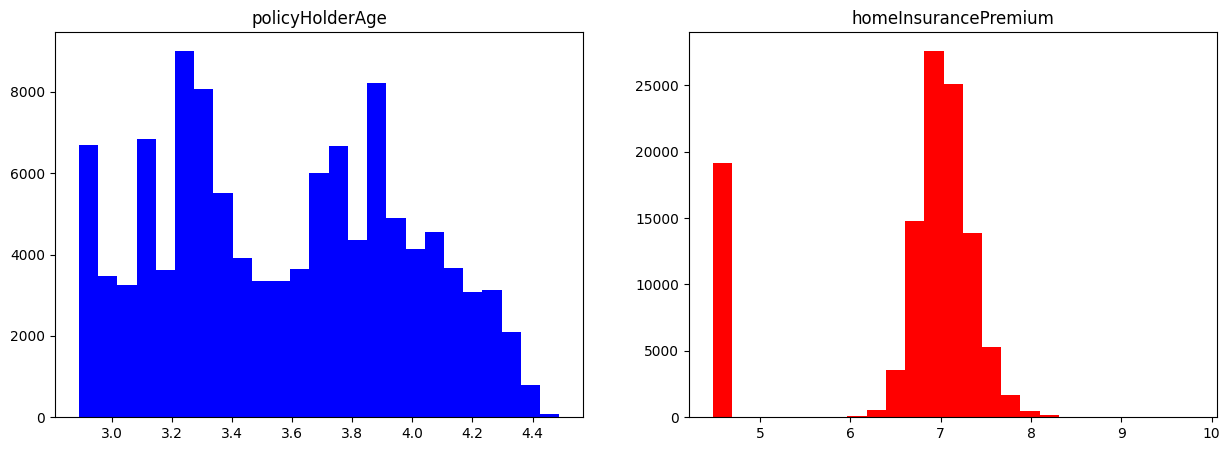

In [9]:
# Correct for policyHolderAge and homeInurancePremium Skewness
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(np.log(x_train["policyHolderAge"]), bins=25, color='blue')
ax[0].set_title('policyHolderAge')

ax[1].hist(np.log(x_train["homeInsurancePremium"]), bins=25, color='red')
ax[1].set_title('homeInsurancePremium')

In [10]:
# Check Outliers for homeInsurancePremium
""" Outliers do exist within the homeInsurancePremium variable. However, having more than one outlier means they did not come by mistake. Hence, they will be kept but with caution. """
mask = x_train["homeInsurancePremium"] > 4000
print(mask.sum())

107


In [11]:
# Check for Colinearity
x_train[["policyHolderAge", "homeInsurancePremium", "nbWeeksInsured"]].corr()

,policyHolderAge,homeInsurancePremium,nbWeeksInsured
policyHolderAge,1.000000,0.069785,-0.002644
homeInsurancePremium,0.069785,1.000000,-0.004468
nbWeeksInsured,-0.002644,-0.004468,1.000000


#### 3.1.2 Categorical Variables - High Cardinality

In [12]:
# One can use: frequency encoding, target encoding, hashing trick encoding, or embeding
# Check the Number of Distinct Values - Variables are already Label Encoded!
x_train[["territory", "saleChannel"]].nunique()

territory       53
saleChannel    144
dtype: int64

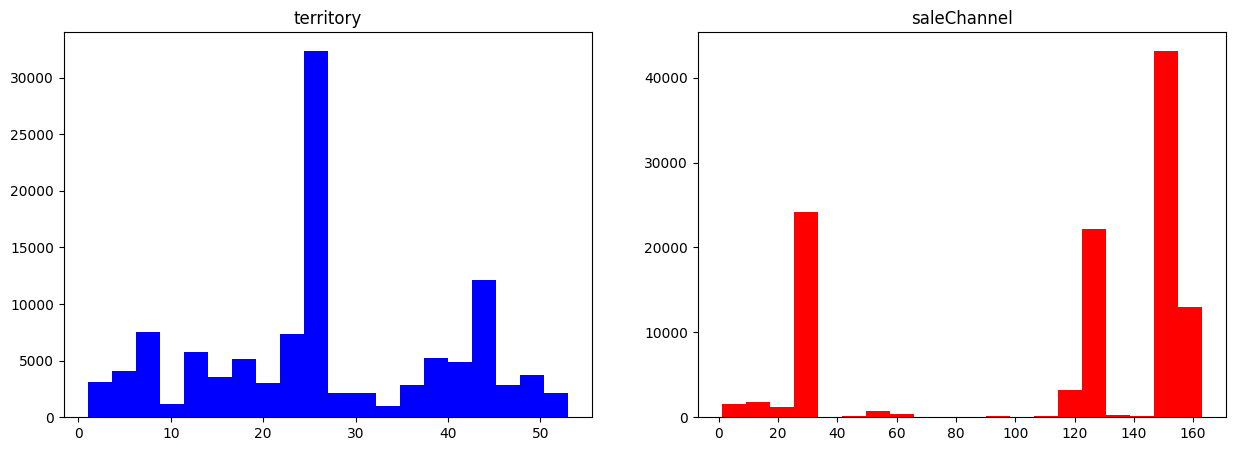

In [13]:
# Plot a Histogram of the Variables
ig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(x_train["territory"], bins=20, color='blue')
ax[0].set_title('territory')
ax[1].hist(x_train["saleChannel"], bins=20, color='red')
ax[1].set_title('saleChannel')

fig.tight_layout()

plt.show()

In [14]:
# Check for Categorical Dependence
# Comment: Some p-values are zero which indicates there is a relationship between their corresponding variables.
#          A low p-value doesn't necessarily mean the relationship is strong, and it doesn't provide information about the nature or strength of the relationship.
#          In addition, a low p-value could also mean that the sample size is large enough to detect even small differences between observed and expected frequencies.
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(index=x_train["territory"], columns=x_train["saleChannel"])
stat, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square Statistic is: " + str(stat))
print("p-value is: " + str(p))
print("Number of DOFs is: " + str(dof))


Chi-square Statistic is: 147869.77952523652
p-value is: 0.0
Number of DOFs is: 7436


#### 3.1.3 Categorical Variables - Low Cardinality

In [15]:
# Check Frequencies of Categorical Variables
print(x_train[["Gender"]].value_counts())
print("---------")
print(x_train[["hasCanadianDrivingLicense" ]].value_counts())
print("---------")
print(x_train[["hasAutoInsurance"]].value_counts())
print("---------")
print(x_train[["hadVehicleClaimInPast"]].value_counts())
print("---------")
print(x_train[["isOwner"]].value_counts())
print("---------")
print(x_train[["rentedVehicle"]].value_counts())
print("---------")
print(x_train[["hasMortgage"]].value_counts())
print("---------")
print(x_train[["vehicleStatus"]].value_counts())

Gender
Male      60801
Female    51601
Name: count, dtype: int64
---------
hasCanadianDrivingLicense
1                            112173
0                               229
Name: count, dtype: int64
---------
hasAutoInsurance
0                   60900
1                   51502
Name: count, dtype: int64
---------
hadVehicleClaimInPast
Yes                      56865
No                       55537
Name: count, dtype: int64
---------
isOwner
0          78648
1          33754
Name: count, dtype: int64
---------
rentedVehicle
0                61869
1                50533
Name: count, dtype: int64
---------
hasMortgage
1.0            28652
0.0             5102
Name: count, dtype: int64
---------
vehicleStatus 
Recent vehicle    58896
New vehicle       48790
Old vehicle        4716
Name: count, dtype: int64


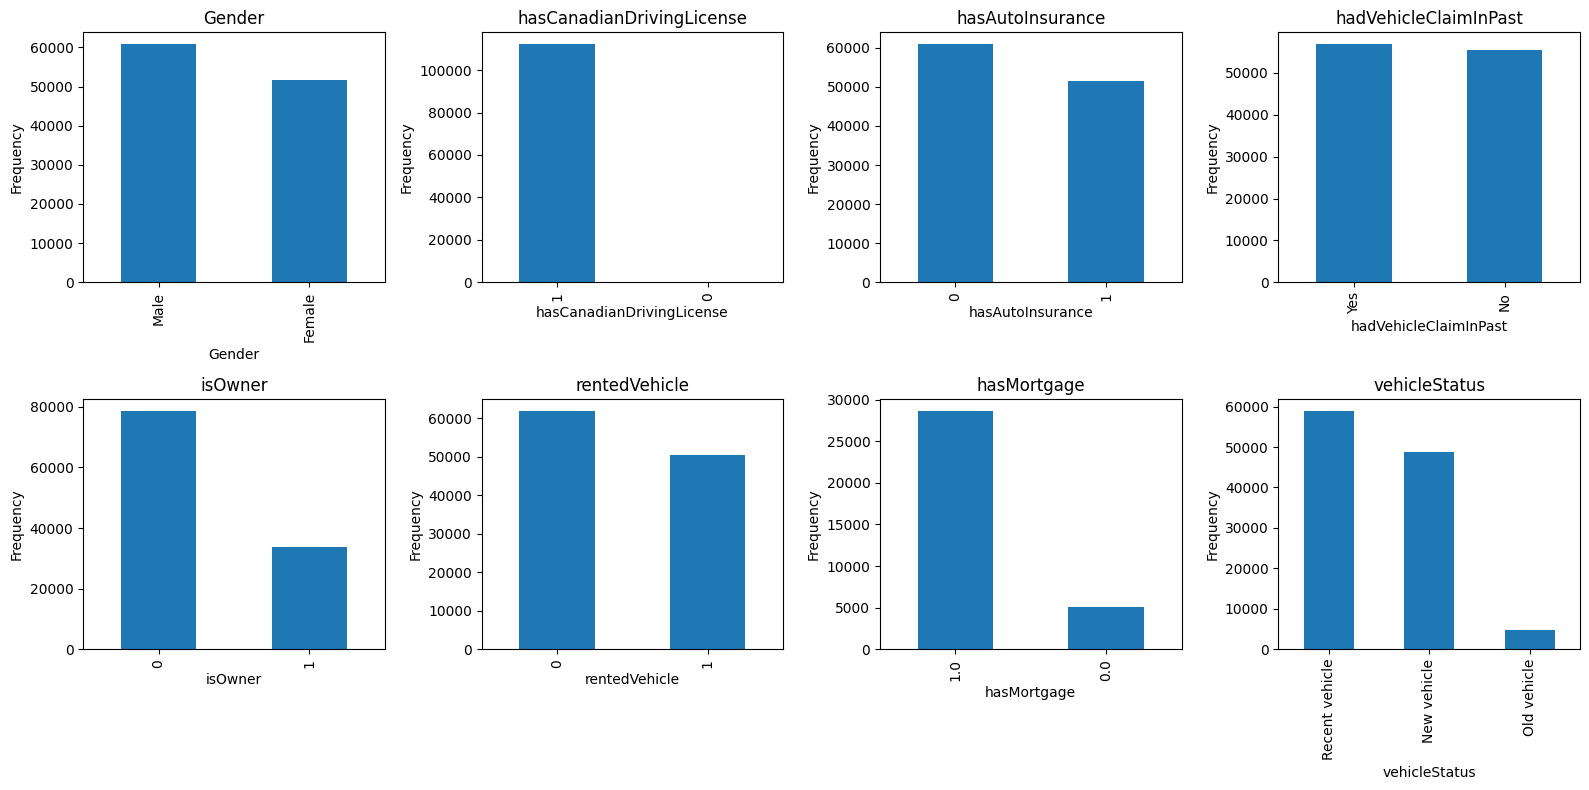

In [16]:
# Plot a Histogram of the Variables
columns = ['Gender', 'hasCanadianDrivingLicense', "hasAutoInsurance", "hadVehicleClaimInPast", "isOwner", "rentedVehicle", "hasMortgage", "vehicleStatus"]

# set the number of rows and columns for the subplot
nrows = 2
ncols = 4

# create the subplot grid
fig, ax = plt.subplots(nrows, ncols, figsize=(16, 8))

# loop through the columns and axes
for i, col in enumerate(columns):
    # calculate the frequency of each category in the column
    freq = x_train[col].value_counts()
    
    # get the axis for the subplot
    axi = ax.flat[i]
    
    # plot the frequency as a bar chart
    freq.plot(kind='bar', ax=axi)
    axi.set_title(col)
    axi.set_xlabel(col)
    axi.set_ylabel('Frequency')

# adjust the layout of the subplots
plt.tight_layout()

# display the plot
plt.show()

In [17]:
# Check for Dependence
# [1] Establish contingency tables
# [2] Perform Chi-squared test
# [3] Comment: Some p-values are zero which indicates there is a relationship between their corresponding variables.
#              A low p-value doesn't necessarily mean the relationship is strong, and it doesn't provide information about the nature or strength of the relationship.
#              In addition, a low p-value could also mean that the sample size is large enough to detect even small differences between observed and expected frequencies.
#              Proceed with caution!
from scipy.stats import chi2_contingency

p_matrix = -1 * np.ones((len(columns), len(columns)))

for i in range(len(columns)):
    for j in range(i+1, len(columns)):
        
        contingency_table = pd.crosstab(index=x_train[columns[i]], columns=x_train[columns[j]])
        stat, p, dof, expected = chi2_contingency(contingency_table)
        
        p_matrix[i, j] = np.round(p, 5)
        
print(p_matrix)

[[-1.       0.       0.       0.       0.75267  0.373    0.8553   0.     ]
 [-1.      -1.       0.       0.       0.23281  0.12465  0.87649  0.     ]
 [-1.      -1.      -1.       0.       0.85079  0.49619  0.0511   0.     ]
 [-1.      -1.      -1.      -1.       0.82594  0.35255  0.02266  0.     ]
 [-1.      -1.      -1.      -1.      -1.       0.68112  1.       0.22916]
 [-1.      -1.      -1.      -1.      -1.      -1.       0.16357  0.79043]
 [-1.      -1.      -1.      -1.      -1.      -1.      -1.       0.30532]
 [-1.      -1.      -1.      -1.      -1.      -1.      -1.      -1.     ]]


#### 3.1.4 Response Variable

In [18]:
# Check Response Variable for Class Imbalance
target_imbalance = (y_train.value_counts()/x_train.shape[0]) * 100
target_imbalance

responseVariable
0    87.678155
1    12.321845
Name: count, dtype: float64

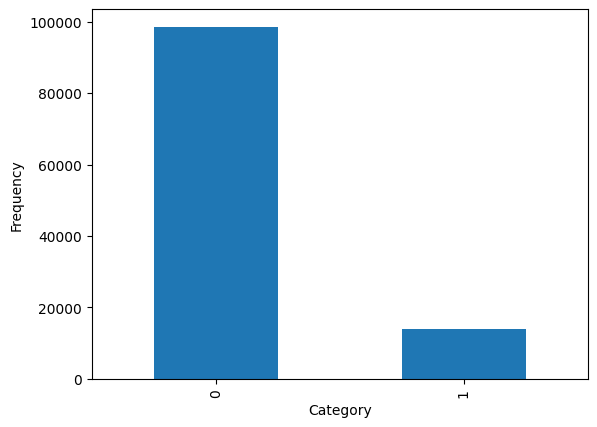

In [19]:
# Plot Classes
frequency = y_train.value_counts()

# Plot the frequency using a bar plot
frequency.plot(kind='bar')

# Add labels to the x and y axes
plt.xlabel('Category')
plt.ylabel('Frequency')

# Display the plot
plt.show()

### [3.2] Check for Missing Values

In [20]:
# NA Values in "hasMortgage" means the house is rented. Hence, it needs to be imputed as a third category!
x_train.isna().sum()

Gender                           0
policyHolderAge                  0
hasCanadianDrivingLicense        0
territory                        0
hasAutoInsurance                 0
hadVehicleClaimInPast            0
homeInsurancePremium             0
saleChannel                      0
isOwner                          0
rentedVehicle                    0
hasMortgage                  78648
nbWeeksInsured                   0
vehicleStatus                    0
dtype: int64

### [3.3] Data Pre-processing Pipelines
Create a set of data preprocessing pipelines.

In [21]:
# Create Columns Lists
num_features = ["policyHolderAge", "homeInsurancePremium", "nbWeeksInsured"]
cat_long_features = ["territory", "saleChannel"]
cat_features = ['Gender', 'hasCanadianDrivingLicense', "hasAutoInsurance", "hadVehicleClaimInPast", "isOwner", "rentedVehicle", "hasMortgage", "vehicleStatus"]

##### Transformer #1
Imputation + Categorical Encodings

In [22]:
impute_and_onehot_pipe = Pipeline(steps=[
                                            ('imputer', SimpleImputer(strategy='constant', fill_value=2)),
                                            ('onehot', OneHotEncoder(handle_unknown='ignore'))
                                        ])


preprocessing_transformer1 = ColumnTransformer(transformers=[
                                                                ('genderPipe', OneHotEncoder(handle_unknown='ignore'), ["Gender"]),
                                                                ('vehicleClaimPipe', OneHotEncoder(handle_unknown='ignore'), ["hadVehicleClaimInPast"]),
                                                                ('hasMortgagePipe', impute_and_onehot_pipe, ["hasMortgage"]),
                                                                ('vehicleStatusPipe', OneHotEncoder(handle_unknown='ignore'), ["vehicleStatus"])
                                                            ], remainder='passthrough')

preprocessing_pipeline1 = Pipeline([
                                      ('transform_column', preprocessing_transformer1)
                                   ])
preprocessing_pipeline1


Pipeline(steps=[('transform_column',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('genderPipe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender']),
                                                 ('vehicleClaimPipe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['hadVehicleClaimInPast']),
                                                 ('hasMortgagePipe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=2,
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['hasMortgage']),
                                                 ('vehicleStatusPipe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['vehicleStatus'])]))])

##### Transformer #2
Imputation + Categorical Encodings + Numeric Standardization

In [23]:
impute_and_onehot_pipe = Pipeline(steps=[
                                            ('imputer', SimpleImputer(strategy='constant', fill_value=2)),
                                            ('onehot', OneHotEncoder(handle_unknown='ignore'))
                                        ])


preprocessing_transformer2 = ColumnTransformer(transformers=[
                                                                ("numericPipe_log", FunctionTransformer(np.log, validate=True), ["policyHolderAge", "homeInsurancePremium"]),
                                                                ("numericPipe", StandardScaler(), num_features),
                                                                ('genderPipe', OneHotEncoder(handle_unknown='ignore'), ["Gender"]),
                                                                ('vehicleClaimPipe', OneHotEncoder(handle_unknown='ignore'), ["hadVehicleClaimInPast"]),
                                                                ('hasMortgagePipe', impute_and_onehot_pipe, ["hasMortgage"]),
                                                                ('vehicleStatusPipe', OneHotEncoder(handle_unknown='ignore'), ["vehicleStatus"])
                                                            ], remainder='passthrough')

preprocessing_pipeline2 = Pipeline([
                                      ('transform_column', preprocessing_transformer2)
                                   ])
preprocessing_pipeline2

Pipeline(steps=[('transform_column',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numericPipe_log',
                                                  FunctionTransformer(func=<ufunc 'log'>,
                                                                      validate=True),
                                                  ['policyHolderAge',
                                                   'homeInsurancePremium']),
                                                 ('numericPipe',
                                                  StandardScaler(),
                                                  ['policyHolderAge',
                                                   'homeInsurancePremium',
                                                   'nbWeeksInsured']),
                                                 ('genderPipe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender']),
                                                 ('vehicleClaimPipe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['hadVehicleClaimInPast']),
                                                 ('hasMortgagePipe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=2,
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['hasMortgage']),
                                                 ('vehicleStatusPipe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['vehicleStatus'])]))])

##### Transformer #3
Imputation + Categorical Encodings + Numeric and Cat_long Standardization

In [24]:
import category_encoders as ce

impute_and_onehot_pipe = Pipeline(steps=[
                                            ('imputer', SimpleImputer(strategy='constant', fill_value=2)),
                                            ('onehot', OneHotEncoder(handle_unknown='ignore'))
                                        ])


preprocessing_transformer3 = ColumnTransformer(transformers=[
                                                                ("numericPipe_log", FunctionTransformer(np.log, validate=True), ["policyHolderAge", "homeInsurancePremium"]),
                                                                ("numericPipe", StandardScaler(), num_features),
                                                                ("catLongPipe", StandardScaler(), cat_long_features),
                                                                ('genderPipe', OneHotEncoder(handle_unknown='ignore'), ["Gender"]),
                                                                ('vehicleClaimPipe', OneHotEncoder(handle_unknown='ignore'), ["hadVehicleClaimInPast"]),
                                                                ('hasMortgagePipe', impute_and_onehot_pipe, ["hasMortgage"]),
                                                                ('vehicleStatusPipe', OneHotEncoder(handle_unknown='ignore'), ["vehicleStatus"]),
                                                            ], remainder='passthrough')

preprocessing_pipeline3 = Pipeline([
                                      ('transform_column', preprocessing_transformer3)
                                   ])
preprocessing_pipeline3

Pipeline(steps=[('transform_column',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numericPipe_log',
                                                  FunctionTransformer(func=<ufunc 'log'>,
                                                                      validate=True),
                                                  ['policyHolderAge',
                                                   'homeInsurancePremium']),
                                                 ('numericPipe',
                                                  StandardScaler(),
                                                  ['policyHolderAge',
                                                   'homeInsurancePremium',
                                                   'nbWeeksInsured']),
                                                 ('catLongPipe',
                                                  StandardScaler(),
                                                  ['territory', 'sal...
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender']),
                                                 ('vehicleClaimPipe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['hadVehicleClaimInPast']),
                                                 ('hasMortgagePipe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=2,
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['hasMortgage']),
                                                 ('vehicleStatusPipe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['vehicleStatus'])]))])

##### Transformer #4
Imputation + Categorical Encodings + Numeric Standardization + Count Encoding (cat_long_features)

In [25]:
import category_encoders as ce

impute_and_onehot_pipe = Pipeline(steps=[
                                            ('imputer', SimpleImputer(strategy='constant', fill_value=2)),
                                            ('onehot', OneHotEncoder(handle_unknown='ignore'))
                                        ])


preprocessing_transformer4 = ColumnTransformer(transformers=[
                                                                ("numericPipe_log", FunctionTransformer(np.log, validate=True), ["policyHolderAge", "homeInsurancePremium"]),
                                                                ("numericPipe", StandardScaler(), num_features),
                                                                ('genderPipe', OneHotEncoder(handle_unknown='ignore'), ["Gender"]),
                                                                ('vehicleClaimPipe', OneHotEncoder(handle_unknown='ignore'), ["hadVehicleClaimInPast"]),
                                                                ('hasMortgagePipe', impute_and_onehot_pipe, ["hasMortgage"]),
                                                                ('vehicleStatusPipe', OneHotEncoder(handle_unknown='ignore'), ["vehicleStatus"]),
                                                            ], remainder='passthrough')

preprocessing_pipeline4 = Pipeline([
                                      ("terr_Encoder", ce.CountEncoder(cols=["territory"], return_df=True)),
                                      ("saleChannel_Encoder", ce.CountEncoder(cols=["saleChannel"], return_df=True)),
                                      ('transform_column', preprocessing_transformer4)
                                   ])
preprocessing_pipeline4

Pipeline(steps=[('terr_Encoder',
                 CountEncoder(cols=['territory'], combine_min_nan_groups=True)),
                ('saleChannel_Encoder',
                 CountEncoder(cols=['saleChannel'],
                              combine_min_nan_groups=True)),
                ('transform_column',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numericPipe_log',
                                                  FunctionTransformer(func=<ufunc 'log'>,
                                                                      validate=True),
                                                  ['policyHolderAge',
                                                   'h...
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender']),
                                                 ('vehicleClaimPipe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['hadVehicleClaimInPast']),
                                                 ('hasMortgagePipe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=2,
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['hasMortgage']),
                                                 ('vehicleStatusPipe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['vehicleStatus'])]))])

##### Transformer #5
Imputation + Categorical Encodings + Numeric Standardization + Count Encoding (cat_long_features) + Normalization (cat_long_features)

In [26]:
import category_encoders as ce

impute_and_onehot_pipe = Pipeline(steps=[
                                            ('imputer', SimpleImputer(strategy='constant', fill_value=2)),
                                            ('onehot', OneHotEncoder(handle_unknown='ignore'))
                                        ])


preprocessing_transformer5 = ColumnTransformer(transformers=[                                        
                                                                ("numericPipe_log", FunctionTransformer(np.log, validate=True), ["policyHolderAge", "homeInsurancePremium"]),
                                                                ("numericPipe", StandardScaler(), num_features),
                                                                ("catLongPipe", StandardScaler(), cat_long_features),
                                                                ('genderPipe', OneHotEncoder(handle_unknown='ignore'), ["Gender"]),
                                                                ('vehicleClaimPipe', OneHotEncoder(handle_unknown='ignore'), ["hadVehicleClaimInPast"]),
                                                                ('hasMortgagePipe', impute_and_onehot_pipe, ["hasMortgage"]),
                                                                ('vehicleStatusPipe', OneHotEncoder(handle_unknown='ignore'), ["vehicleStatus"]),
                                                              ], remainder='passthrough')

preprocessing_pipeline5 = Pipeline([
                                        ("terr_Encoder", ce.CountEncoder(cols=["territory"], return_df=True)),
                                        ("saleChannel_Encoder", ce.CountEncoder(cols=["saleChannel"], return_df=True)),
                                        ('transform_column', preprocessing_transformer5)
                                   ])

preprocessing_pipeline5

Pipeline(steps=[('terr_Encoder',
                 CountEncoder(cols=['territory'], combine_min_nan_groups=True)),
                ('saleChannel_Encoder',
                 CountEncoder(cols=['saleChannel'],
                              combine_min_nan_groups=True)),
                ('transform_column',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numericPipe_log',
                                                  FunctionTransformer(func=<ufunc 'log'>,
                                                                      validate=True),
                                                  ['policyHolderAge',
                                                   'h...
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender']),
                                                 ('vehicleClaimPipe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['hadVehicleClaimInPast']),
                                                 ('hasMortgagePipe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=2,
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['hasMortgage']),
                                                 ('vehicleStatusPipe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['vehicleStatus'])]))])

##### Transformer #6
Imputation + Categorical Encodings + Numeric Standardization + Target Encoding (cat_long_features)

In [27]:
import category_encoders as ce

impute_and_onehot_pipe = Pipeline(steps=[
                                            ('imputer', SimpleImputer(strategy='constant', fill_value=2)),
                                            ('onehot', OneHotEncoder(handle_unknown='ignore'))
                                        ])


preprocessing_transformer6 = ColumnTransformer(transformers=[
                                                                ("numericPipe_log", FunctionTransformer(np.log, validate=True), ["policyHolderAge", "homeInsurancePremium"]),
                                                                ("numericPipe", StandardScaler(), num_features),
                                                                ('genderPipe', OneHotEncoder(handle_unknown='ignore'), ["Gender"]),
                                                                ('vehicleClaimPipe', OneHotEncoder(handle_unknown='ignore'), ["hadVehicleClaimInPast"]),
                                                                ('hasMortgagePipe', impute_and_onehot_pipe, ["hasMortgage"]),
                                                                ('vehicleStatusPipe', OneHotEncoder(handle_unknown='ignore'), ["vehicleStatus"]),
                                                            ], remainder='passthrough')

# You need to optimize the smoothing parameter through cross-validation.
preprocessing_pipeline6 = Pipeline([
                                      ("terr_Encoder", ce.TargetEncoder(cols=["territory"], return_df=True)),
                                      ("saleChannel_Encoder", ce.TargetEncoder(cols=["saleChannel"], return_df=True)),
                                      ('transform_column', preprocessing_transformer6)
                                   ])
preprocessing_pipeline6

Pipeline(steps=[('terr_Encoder', TargetEncoder(cols=['territory'])),
                ('saleChannel_Encoder', TargetEncoder(cols=['saleChannel'])),
                ('transform_column',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numericPipe_log',
                                                  FunctionTransformer(func=<ufunc 'log'>,
                                                                      validate=True),
                                                  ['policyHolderAge',
                                                   'homeInsurancePremium']),
                                                 ('numericPipe',
                                                  StandardScaler()...
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender']),
                                                 ('vehicleClaimPipe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['hadVehicleClaimInPast']),
                                                 ('hasMortgagePipe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=2,
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['hasMortgage']),
                                                 ('vehicleStatusPipe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['vehicleStatus'])]))])

##### Transformer #7
Imputation + Categorical Encodings + Numeric Standardization + Target Encoding (cat_long_features) + Normalization (cat_long_features)

In [28]:
import category_encoders as ce

impute_and_onehot_pipe = Pipeline(steps=[
                                            ('imputer', SimpleImputer(strategy='constant', fill_value=2)),
                                            ('onehot', OneHotEncoder(handle_unknown='ignore'))
                                        ])


preprocessing_transformer7 = ColumnTransformer(transformers=[
                                                                ("numericPipe_log", FunctionTransformer(np.log, validate=True), ["policyHolderAge", "homeInsurancePremium"]),
                                                                ("numericPipe", StandardScaler(), num_features),
                                                                ("catLongPipe", StandardScaler(), cat_long_features),
                                                                ('genderPipe', OneHotEncoder(handle_unknown='ignore'), ["Gender"]),
                                                                ('vehicleClaimPipe', OneHotEncoder(handle_unknown='ignore'), ["hadVehicleClaimInPast"]),
                                                                ('hasMortgagePipe', impute_and_onehot_pipe, ["hasMortgage"]),
                                                                ('vehicleStatusPipe', OneHotEncoder(handle_unknown='ignore'), ["vehicleStatus"]),
                                                              ], remainder='passthrough')

preprocessing_pipeline7 = Pipeline([
                                        ("terr_Encoder", ce.TargetEncoder(cols=["territory"], return_df=True)),
                                        ("saleChannel_Encoder", ce.TargetEncoder(cols=["saleChannel"], return_df=True)),
                                        ('transform_column', preprocessing_transformer7)
                                   ])

preprocessing_pipeline7

Pipeline(steps=[('terr_Encoder', TargetEncoder(cols=['territory'])),
                ('saleChannel_Encoder', TargetEncoder(cols=['saleChannel'])),
                ('transform_column',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numericPipe_log',
                                                  FunctionTransformer(func=<ufunc 'log'>,
                                                                      validate=True),
                                                  ['policyHolderAge',
                                                   'homeInsurancePremium']),
                                                 ('numericPipe',
                                                  StandardScaler()...
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender']),
                                                 ('vehicleClaimPipe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['hadVehicleClaimInPast']),
                                                 ('hasMortgagePipe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=2,
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['hasMortgage']),
                                                 ('vehicleStatusPipe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['vehicleStatus'])]))])

## [4] Prediction Models

In [29]:
# Import Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Import Evaluation Metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc

In [30]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", message=".*FitFailedWarning.*")

#### [4.1] Logistic Regression

In [ ]:
# Model Pipeline
logRegPipe = Pipeline(
                        steps=[
                                    ("preprocessing", preprocessing_pipeline5),
                                    ("logReg", LogisticRegression(random_state=10, class_weight="balanced", solver="sag"))
                              ]
                  )

# Model Parameter Tuning
logRegPipe_SS = [{
                        'logReg__penalty': ['l1', 'l2'],
                        'logReg__C': [0.1, 1, 10, 100],
                        'logReg__solver': ['lbfgs']
            }]
logRegPipe_GCV = GridSearchCV(logRegPipe, logRegPipe_SS, cv=5, verbose=0, n_jobs=-1)

# Evaluate Cross-validation Score
logReg_evalMeasures = cross_validate(logRegPipe_GCV, x_train, y_train, scoring=["accuracy", "precision", "recall", "f1" ])

In [44]:
for metric in ["test_accuracy", "test_precision", "test_recall", "test_f1"]:
    mean_score = np.mean(logReg_evalMeasures[metric])
    std_score = np.std(logReg_evalMeasures[metric])
    print(f"{metric}: {mean_score:.3f} ± {std_score:.3f}")

test_accuracy: 0.673 ± 0.004
test_precision: 0.267 ± 0.003
test_recall: 0.941 ± 0.005
test_f1: 0.416 ± 0.004


In [ ]:
logRegPipe_M = logRegPipe_GCV.fit(x_train, y_train)

# Obtain predicted probabilities for the test data
y_pred_proba = logRegPipe_GCV.predict_proba(x_test)

# Compute the false positive rate, true positive rate, and thresholds for different probability cutoffs
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])

# Compute the area under the curve (AUC)
roc_auc = auc(fpr, tpr)

In [46]:
# Print Results
print("tp Rate: " + str(np.round(tpr.mean(), 3)))
print("fp Rate: " + str(np.round(fpr.mean(), 3)))
print("ROC - AUC: " + str(np.round(roc_auc, 3)))

tp Rate: 0.525
fp Rate: 0.17
ROC - AUC: 0.841


In [47]:
# Check Best Parameters
logRegPipe_M.best_params_

{'logReg__C': 100, 'logReg__penalty': 'l2', 'logReg__solver': 'lbfgs'}

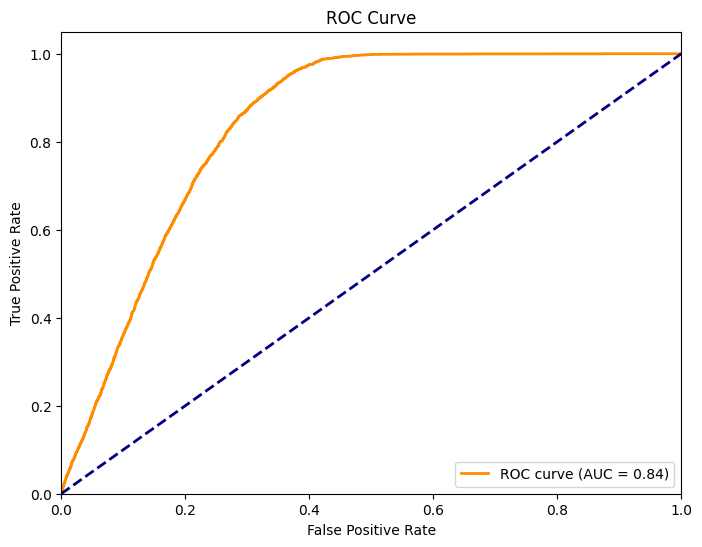

In [48]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

#### [4.2] Random Forests

In [32]:
# Model Pipeline
RFPipe = Pipeline(
                        steps=[
                                    ("preprocessing", preprocessing_pipeline1),
                                    ("RF", RandomForestClassifier(random_state=10, class_weight="balanced"))
                              ]
                  )

# Model Parameter Tuning
RFPipe_SS = [{
                        "RF__n_estimators": np.linspace(100, 500, 4, dtype=int),
                        "RF__max_depth": np.array([5, 7, 9]),
                        "RF__max_features": np.array([5, 7, 9]),                
                        "RF__min_samples_leaf": np.linspace(5, 25, 3, dtype=int)               
            }]
RFPipe_GCV = GridSearchCV(RFPipe, RFPipe_SS, cv=3, verbose=0, n_jobs=-1)

# Evaluate Cross-validation Score
RF_evalMeasures = cross_validate(RFPipe_GCV, x_train, y_train, scoring=["accuracy", "precision", "recall", "f1" ])

In [33]:
for metric in ["test_accuracy", "test_precision", "test_recall", "test_f1"]:
    mean_score = np.mean(RF_evalMeasures[metric])
    std_score = np.std(RF_evalMeasures[metric])
    print(f"{metric}: {mean_score:.3f} ± {std_score:.3f}")

test_accuracy: 0.692 ± 0.003
test_precision: 0.277 ± 0.001
test_recall: 0.931 ± 0.008
test_f1: 0.427 ± 0.001


In [34]:
RFPipe_M = RFPipe_GCV.fit(x_train, y_train)

# Obtain predicted probabilities for the test data
y_pred_proba = RFPipe_GCV.predict_proba(x_test)

# Compute the false positive rate, true positive rate, and thresholds for different probability cutoffs
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])

# Compute the area under the curve (AUC)
roc_auc = auc(fpr, tpr)

In [35]:
# Print Results
print("tp Rate: " + str(np.round(tpr, 3)))
print("fp Rate: " + str(np.round(fpr, 3)))
print("AUC: " + str(np.round(roc_auc, 3)))

tp Rate: [0. 0. 0. ... 1. 1. 1.]
fp Rate: [0.    0.    0.    ... 0.999 0.999 1.   ]
AUC: 0.845


In [36]:
# Check Best Parameters
RFPipe_GCV.best_params_

{'RF__max_depth': np.int64(9),
 'RF__min_samples_leaf': np.int64(5),
 'RF__n_estimators': np.int64(100)}

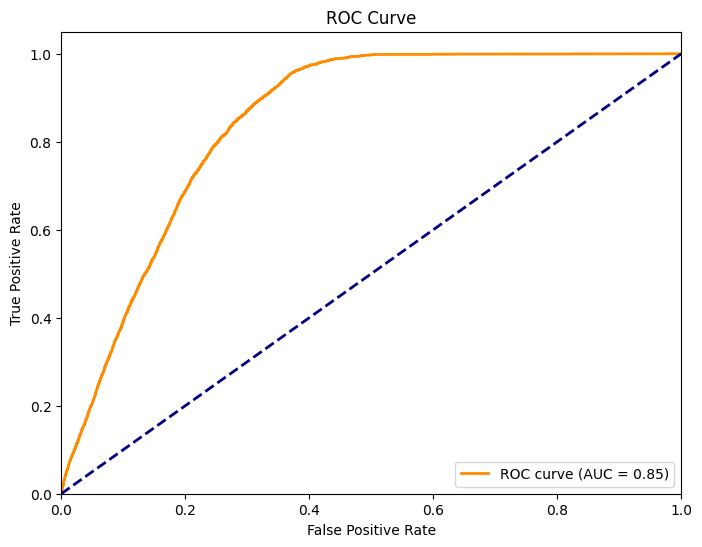

In [37]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

#### [4.3] SVM

In [ ]:
# Model Pipeline
SVMPipe = Pipeline(
                        steps=[
                                    ("preprocessing", preprocessing_pipeline3),
                                    ("SVM", SVC(random_state=10, class_weight="balanced", kernel="rbf"))
                              ]
                  )

# Model Parameter Tuning
SVMPipe_SS = [{
                        "SVM__C": np.linspace(1, 100, 2),
                        "SVM__gamma": np.linspace(1, 100, 2)
                        
            }]
SVMPipe_GCV = GridSearchCV(SVMPipe, SVMPipe_SS, cv=2, verbose=2, n_jobs=-1)

# Evaluate Cross-validation Score
SVM_evalMeasures = cross_validate(SVMPipe_GCV, x_train, y_train, scoring=["accuracy", "precision", "recall", "f1" ])

In [ ]:
for metric in ["test_accuracy", "test_precision", "test_recall", "test_f1"]:
    mean_score = np.mean(SVM_evalMeasures[metric])
    std_score = np.std(SVM_evalMeasures[metric])
    print(f"{metric}: {mean_score:.3f} ± {std_score:.3f}")

In [ ]:
SVMPipe_M = SVMPipe_GCV.fit(x_train, y_train)

# Obtain predicted probabilities for the test data
y_pred_proba = SVMPipe_GCV.predict_proba(x_test)

# Compute the false positive rate, true positive rate, and thresholds for different probability cutoffs
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])

# Compute the area under the curve (AUC)
roc_auc = auc(fpr, tpr)

In [ ]:
# Print Results
print("tp Rate: " + str(np.round(tpr, 3)))
print("fp Rate: " + str(np.round(fpr, 3)))
print("AUC: " + str(np.round(roc_auc, 3)))

In [ ]:
# Check Best Parameters
SVMPipe_GCV.best_params_

In [ ]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## [5] Scoring Dataset Predictions

In [ ]:
# Load Dataset
data_comp = pd.read_csv("ScoringDataset_2023Qualification.csv")

In [ ]:
# Load Features
x_comp = data_comp.iloc[:, 1:]

In [ ]:
# Predict Results
comp_predictions = RFPipe_GCV.predict_proba(x_comp)
comp_predictions

In [ ]:
threshold = 0.5

# Convert probabilities into zeros and ones using the threshold value
binary_predictions = np.where(comp_predictions > threshold, 1, 0)

# Print the binary predictions
binary_predictions.shape

In [ ]:
# Export to DF
pred_df = pd.DataFrame(binary_predictions)
pred_df.to_csv('comp_dataframe.csv', index=False)